<a href="https://colab.research.google.com/github/kkmm001/bool_ml_finance/blob/main/supervised_portfolios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install arch # Financial econometrics module

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import os
import time
import pickle
from datetime import datetime,timedelta
from pandas.tseries.offsets import BDay
from joblib import Parallel, delayed, parallel_backend
from arch.bootstrap import MCS
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cvxpy as cp
import scipy.stats as ss
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import QuantileTransformer
import xgboost as xgb
import itertools
from plotnine import *

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [4]:
# Useful functions

def init_encoder(df, col_names_list):
    d = {}
    for col_name in col_names_list:
        d[col_name] = df[col_name].unique().tolist()
    return d

def one_hot_encoder(df, var_dict):
    for var, vals in var_dict.items():
        for val in vals:
            df[val] = df[var].apply(lambda x: 1 if x == val else 0)
    return df

def get_turnover(df_returns,df_weights):
    
    df_fwd_adj_wgt = (1+df_returns)*df_weights.shift() 
    turnover = (df_weights-df_fwd_adj_wgt).abs().sum(axis=1,skipna=False)
    return turnover

def max_drawdown(returns):

    if len(returns) < 1:
        return np.nan

    cumulative = 100 * (1+returns).cumprod()
    max_return = cumulative.cummax()
    return cumulative.sub(max_return).div(max_return).min()


def sharpe_ratio(returns, risk_free_rate=0, nperiods=252, annualize=True):

    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns)
    if annualize:
        return np.sqrt(nperiods) * sharpe_ratio

    return sharpe_ratio


def rolling_sharpe_ratio(returns, window, risk_free_rate=0, frequency='daily'):

    if frequency == 'daily':
        nperiods = 252

    elif frequency == 'weekly':
        nperiods = 52

    elif frequency == 'monthly':
        nperiods = 12

    rolling_sr = returns.rolling(window).apply(sharpe_ratio, raw=True,
                                               kwargs={'risk_free_rate': risk_free_rate,
                                                       'nperiods': nperiods})
    rolling_sr.dropna(inplace=True)

    return rolling_sr


### Retrieve Open Source Dataset

In [5]:
# GET DATA
DATAPATH = r'./opensource_data' # csv files downloaded using below open sources links:

# http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Industry_Portfolios_daily_CSV.zip
df_snp_sectors_returns = pd.read_csv(os.path.join(DATAPATH,'10_Industry_Portfolios_Daily.csv'),sep=',', index_col=[0],header=[5], parse_dates=[0])#, skipfooter=1, engine='python')
df_snp_sectors_returns.index = df_snp_sectors_returns.index.rename('date')
df_snp_sectors_returns.dropna(inplace=True)
df_snp_sectors_returns.index = pd.to_datetime(df_snp_sectors_returns.index)
df_snp_sectors_returns = df_snp_sectors_returns.resample('B').last() # ensure time series are in business days
df_snp_sectors_returns = df_snp_sectors_returns.astype(float)
df_snp_sectors_returns.dropna(inplace=True)
df_snp_sectors_returns/=100 # put back into decimal range
df_snp_sectors_returns = df_snp_sectors_returns.loc['1989-12-31':] # limit to more recent years

# https://fred.stlouisfed.org/series/BAMLH0A0HYM2
df_us_hy_spread = pd.read_csv(os.path.join(DATAPATH,'BAMLH0A0HYM2.csv'),sep=',', index_col=[0],header=[0])
df_us_hy_spread = df_us_hy_spread.replace('.',np.nan).astype(float)

# https://fred.stlouisfed.org/series/BAMLC0A2CAA
df_us_aa_spread = pd.read_csv(os.path.join(DATAPATH,'BAMLC0A2CAA.csv'),sep=',', index_col=[0],header=[0])
df_us_aa_spread = df_us_aa_spread.replace('.',np.nan).astype(float)

# https://fred.stlouisfed.org/series/VIXCLS
df_vix = pd.read_csv(os.path.join(DATAPATH,'VIXCLS.csv'),sep=',', index_col=[0],header=[0])
df_vix = df_vix.rename(columns={'VIXCLS':'vix'})
df_vix = df_vix.replace('.',np.nan).astype(float)

# https://fred.stlouisfed.org/series/TEDRATE
df_ted_spread = pd.read_csv(os.path.join(DATAPATH,'TEDRATE.csv'),sep=',', index_col=[0],header=[0])
df_ted_spread = df_ted_spread.rename(columns={'TEDRATE':'ted_rate'})
df_ted_spread = df_ted_spread.replace('.',np.nan).astype(float)

# https://fred.stlouisfed.org/series/T10Y3M
df_yield_curve = pd.read_csv(os.path.join(DATAPATH,'T10Y3M.csv'),sep=',', index_col=[0],header=[0])
df_yield_curve = df_yield_curve.rename(columns={'T10Y3M':'t10y3m'})
df_yield_curve = df_yield_curve.replace('.',np.nan).astype(float)

macro_data = (df_us_hy_spread['BAMLH0A0HYM2'] - df_us_aa_spread['BAMLC0A2CAA']).to_frame('credit_spread')
macro_data = macro_data.join(df_vix)
macro_data = macro_data.join(df_ted_spread)
macro_data = macro_data.join(df_yield_curve)
macro_data.index = pd.to_datetime(macro_data.index)
macro_data = macro_data.resample('B').last() # ensure time series are in business days
macro_data.dropna(inplace=True)
macro_data.index = macro_data.index.rename('date')

FileNotFoundError: ignored

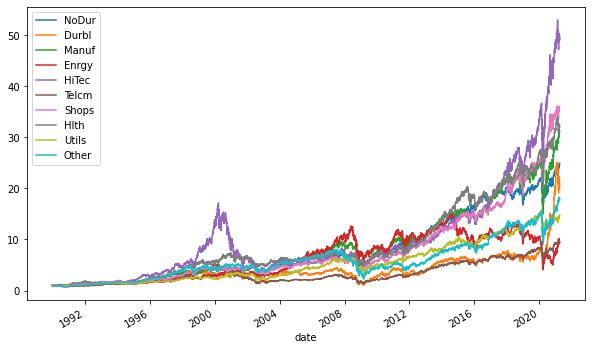

In [ ]:
(1+df_snp_sectors_returns).cumprod().plot(figsize=(10,6));

**Generate Simple Features**

In [ ]:
df_features = {}

for c in df_snp_sectors_returns.columns:

    df_tmp_returns = df_snp_sectors_returns[c]
    df_tmp_levels = (1+df_tmp_returns).cumprod()
    df_tmp = pd.DataFrame(index=df_tmp_returns.index,columns=['mom_1m','mom_3m','mom_6m','mom_1y',
                                                              'vol_1m','vol_3m','vol_6m','vol_1y'])
    df_tmp['mom_1m'] = df_tmp_levels.pct_change(21) * 252 / 21
    df_tmp['mom_3m'] = df_tmp_levels.pct_change(63) * 252 / 63
    df_tmp['mom_6m'] = df_tmp_levels.pct_change(126) * 252 / 126
    df_tmp['mom_1y'] = df_tmp_levels.pct_change(252)
    df_tmp['vol_1m'] = df_tmp_returns.rolling(window=21).std() * np.sqrt(252)
    df_tmp['vol_3m'] = df_tmp_returns.rolling(window=63).std() * np.sqrt(252)
    df_tmp['vol_6m'] = df_tmp_returns.rolling(window=126).std() * np.sqrt(252)
    df_tmp['vol_1y'] = df_tmp_returns.rolling(window=252).std() * np.sqrt(252)
    
    df_features[c] = df_tmp
    
df_features = pd.concat(df_features,axis=1)
df_features.dropna(inplace=True)

### Store parameters of the different approaches

In [ ]:
return_fwd_horizons_days = [21, 63, 126] # expected returns forward looking horizon in days
list_gamma = [1, 3, 10] # risk aversion factors
list_cov_horizon = [63,126,252] # covariance matrix lookback horizon in days (for traditional approach optimization)
list_upper_bounds = [0.2,0.3,0.4] # max weight constraints
list_lower_bounds = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0] # lower bounds weight limits for optimization (i.e long only portfolios)
sum_weights = 1 # Long only portfolio

n = df_snp_sectors_returns.shape[1] # number of instruments in the portfolio
list_dummy_variables = list(df_snp_sectors_returns.columns)
rebalancing_dates = df_snp_sectors_returns.resample('W-FRI').last().index # generate weekly portfolio rebalancing dates
pred_start_date='2001-12-31'
n_jobs_parallel = 4

paper_outputs_path = r'./paper_outputs'

### Generate expected returns target for various horizons

In [ ]:
# If want to predict Y = fwd returns directly (i.e. classic approach):
df_target_returns = {}

for h in return_fwd_horizons_days:
    df_levels = (1 + df_snp_sectors_returns).cumprod()
    df_fwd_returns = df_levels.pct_change(periods = h) # compute return over given horizon
    df_fwd_returns = df_fwd_returns.shift(-h) # bring back forward return to present time
    df_fwd_returns = df_fwd_returns[df_fwd_returns.index.isin(rebalancing_dates)] # convert to weekly time series
    df_target_returns[h] = df_fwd_returns

df_target_returns = pd.concat(df_target_returns, axis=1)
df_target_returns.dropna(inplace=True)

df_XY_ret = {}
df_Y = df_target_returns.copy()

df_XY_tmp = {}

for h in df_Y.columns.levels[0]: #loop over each Y forecast horizons
    df_tmp = df_Y[h].copy()
    Y = {}
    for c in df_tmp.columns:
        Y[c] = df_tmp[c].to_frame('Y')
    Y = pd.concat(Y,axis=1)

    df_h = df_features.join(Y)
    df_h = df_h.stack(level=0).reset_index().rename(columns={'level_1':'sector'}) # convert to panel dataframe
    dict_encoder =init_encoder(df_h,['sector']) #transform sector variable into binary features
    df_h = one_hot_encoder(df_h,dict_encoder)
    df_h = df_h.set_index('date')

    df_XY_tmp[h] = df_h

df_XY_tmp = pd.concat(df_XY_tmp, axis=1)

df_XY_ret['return'] = df_XY_tmp
    
df_XY_ret = pd.concat(df_XY_ret, axis=1)
df_XY_ret.dropna(inplace=True)

In [ ]:
df_XY_ret.head()

return                                                              \
              21                                                                
           sector         Y    mom_1m    mom_1y    mom_3m    mom_6m    vol_1m   
date                                                                            
1991-01-04  Durbl  0.103547 -0.298306 -0.243368 -0.078632 -0.533206  0.146969   
1991-01-04  Enrgy -0.001778 -0.440668 -0.010814 -0.295743 -0.031960  0.109849   
1991-01-04  HiTec  0.180728 -0.014502 -0.040322  0.459715 -0.306591  0.123985   
1991-01-04  Hlth   0.113682 -0.418608  0.103442  0.207380 -0.046992  0.139480   
1991-01-04  Manuf  0.105727  0.090550 -0.100726  0.209135 -0.263400  0.110149   

                                          ...                                \
                                          ...   126                           
              vol_1y    vol_3m    vol_6m  ... Durbl Enrgy HiTec Hlth  Manuf   
date                                      ...                                 
1991-01-04  0.181899  0.206368  0.212958  ...     1     0     0     0     0   
1991-01-04  0.151231  0.138613  0.170698  ...     0     1     0     0     0   
1991-01-04  0.190417  0.210023  0.228961  ...     0     0     1     0     0   
1991-01-04  0.184958  0.176587  0.220651  ...     0     0     0     1     0   
1991-01-04  0.160995  0.171521  0.195871  ...     0     0     0     0     1   

                                          
                                          
           NoDur Other Shops Telcm Utils  
date                                      
1991-01-04     0     0     0     0     0  
1991-01-04     0     0     0     0     0  
1991-01-04     0     0     0     0     0  
1991-01-04     0     0     0     0     0  
1991-01-04     0     0     0     0     0  

[5 rows x 60 columns]

### Generate target weights for new approach

In [ ]:
def func_get_opt_weights_t(df_returns, date_t, fwd_horizon_days=21, bwd_horizon_days=21, is_ret_backward=False,
                           is_vol_backward=True, upper_bounds=1.0, lower_bounds=0.0, sum_weights=1.0, risk_aversion=1.0):
    
    if isinstance(date_t, str):
        date_t = datetime.strptime(date_t,'%Y-%m-%d')
        
    date_fwd_horizon = date_t + BDay(fwd_horizon_days)
    date_bwd_horizon = date_t - BDay(bwd_horizon_days)
    
    fwd_returns = df_returns.loc[date_t:date_fwd_horizon]
    
    if (date_bwd_horizon < df_returns.index.min()) or (date_fwd_horizon > df_returns.index.max()):
        res = pd.Series(index=df_returns.columns,dtype=float)
        return res
    
    if is_ret_backward:
        bwd_cum_returns = (1 + df_returns.loc[date_bwd_horizon:date_t]).cumprod()
        mu = bwd_cum_returns.iloc[-1]/bwd_cum_returns.iloc[0] - 1
        mu_ann = mu * 252 / bwd_horizon_days
    else:    
        fwd_cum_returns = (1 + fwd_returns).cumprod() 
        mu = fwd_cum_returns.iloc[-1]/fwd_cum_returns.iloc[0] - 1
        mu_ann = mu * 252 / fwd_horizon_days
    
    if is_vol_backward:
        cov_matrix = df_returns.loc[date_bwd_horizon:date_t].cov() * 252
    else:
        cov_matrix = fwd_returns.cov() * 252
        
    # mean-variance (Markowitz) optimization
    n, m = df_returns.shape
    w = cp.Variable(m)
    ret = mu_ann.values.T@w 
    risk = cp.quad_form(w, cov_matrix.values)
    constraints = [cp.sum(w) == sum_weights, 
                   w >= lower_bounds, 
                   w <= upper_bounds]
    objective = cp.Maximize(ret - 0.5 * risk_aversion * risk)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    res = pd.Series(index=df_returns.columns, data=w.value)
    
    return res

def func_get_opt_weights_ts(df_returns, rebalancing_dates, fwd_horizon_days=21, bwd_horizon_days=252, 
                            is_ret_backward=False, is_vol_backward=True, upper_bounds=1.0, lower_bounds=0.0, 
                            sum_weights=1.0, risk_aversion=1.0):

    df_opt_wgt = pd.DataFrame(index=rebalancing_dates, columns=df_returns.columns, dtype=float)

    for t in rebalancing_dates:

        opt_wgt_t = func_get_opt_weights_t(df_returns, t, fwd_horizon_days=fwd_horizon_days, 
                                           bwd_horizon_days=bwd_horizon_days, is_ret_backward=is_ret_backward,
                                         is_vol_backward=is_vol_backward, upper_bounds=upper_bounds, lower_bounds=lower_bounds, 
                                         sum_weights=sum_weights, risk_aversion=risk_aversion)

        df_opt_wgt.loc[t] = opt_wgt_t

    return df_opt_wgt

In [ ]:
list_param_iter = list(itertools.product(list_gamma, list_upper_bound))
dict_saved_target = {}

time_start = time.perf_counter()

for g in list_param_iter: # loop through the different optimisation params
    
    upper_bounds = np.repeat(g[1],10) # upper bounds weight limits for optimization
    risk_aversion = g[0] # gamma for mean variance quadratic optimization
    
    # Compute optimized target weights (perfect foresight)
    with parallel_backend('loky', n_jobs=4):
        opt_weights_list = Parallel(prefer="processes", max_nbytes=None)(
            delayed(func_get_opt_weights_ts)(df_snp_sectors_returns, rebalancing_dates, fwd_horizon_days=p, 
                                             bwd_horizon_days=252, 
                                             is_ret_backward=False, is_vol_backward=False, 
                                             upper_bounds=upper_bounds, 
                                             lower_bounds=list_lower_bounds, 
                                             sum_weights=sum_weights, risk_aversion=risk_aversion)
            for p in return_fwd_horizons_days)

    df_target_weights_pf = {}

    for i, j in enumerate(return_fwd_horizons_days):
        df_target_weights_pf[j] = opt_weights_list[i]

    df_target_weights_pf = pd.concat(df_target_weights_pf, axis=1)
    df_target_weights_pf.dropna(inplace=True)
    
    df_target_weights_pf_diff_eqwgt = df_target_weights_pf - 1/n
    
    # Aggregate variables into single panel dataframe
    df_XY = {}

    list_target_variables = ['wgt','wgt1n'] 

    for i in list_target_variables:

        if i == 'wgt':
            df_Y = df_target_weights_pf.copy()

        else:
            df_Y = df_target_weights_pf_diff_eqwgt.copy()

        df_XY_tmp = {}

        for h in df_Y.columns.levels[0]:
            df_tmp = df_Y[h].copy()
            Y = {}
            for c in df_tmp.columns:
                Y[c] = df_tmp[c].to_frame('Y')
            Y = pd.concat(Y,axis=1)

            df_h = df_features.join(Y)
            df_h = df_h.stack(level=0).reset_index().rename(columns={'level_1':'sector'}) # convert to panel dataframe
            #Add categorical (i.e. sectors) features
            dict_encoder =init_encoder(df_h,['sector'])
            df_h = one_hot_encoder(df_h,dict_encoder)
            df_h = df_h.set_index('date')
            df_XY_tmp[h] = df_h

        df_XY_tmp = pd.concat(df_XY_tmp, axis=1)

        df_XY[i] = df_XY_tmp

    df_XY = pd.concat(df_XY, axis=1)
    df_XY.dropna(inplace=True)
    
    dict_saved_targets[f'g_{g[0]}_c_{int(g[1]*10)}'] = df_XY
    
    print(g)
    
dict_saved_targets['ret'] = df_XY_ret # Add the forecast return target dataframe
    
time_elapsed = (time.perf_counter() - time_start)
print('time:' + str(timedelta(seconds=time_elapsed)))

(1, 0.2)
(1, 0.3)
(1, 0.4)
(3, 0.2)
(3, 0.3)
(3, 0.4)
(10, 0.2)
(10, 0.3)
(10, 0.4)
time:0:05:29.932958


### Define functions used for panel regression prediction models

In [ ]:
def func_ecdf(x):
    # Function used for xs normalisation using Empirical Cumulative Distribution Function
    ecdf = ECDF(x)
    res = pd.Series(index=x.index, name=x.name, data=ecdf(x))
    return res


def tanh_normalization(y, mean_series, std_series):
    y_mean = mean_series[y.name]
    y_std = std_series[y.name]
    y_norm = 0.5 * (np.tanh(0.01 * ((y - y_mean) / y_std)))
    return y_norm


def arctanh_normalization(y, mean_series, std_series):
    y_mean = mean_series[y.name]
    y_std = std_series[y.name]
    y_norm = np.arctanh(y/0.5) * (y_std/0.01) + y_mean
    return y_norm


def compute_scaled_features(df1, df2, col_name):
    # Used to scale specific features with macro data (increases the number of explicative variables)
    df_res = df1.join(df2[col_name])
    df_res = df_res.multiply(df_res[col_name], axis=0)
    df_res = df_res.drop(columns=[col_name])
    df_res = df_res.add_suffix('_' + col_name)
    return df_res

def xgb_panel_regressor(xgb_params, X, y, date_t, macro_data_ts=None, xs_normalization: str = 'ECDF',
                        purge_overlap_days: int = 21,
                        list_dummy_variables=None,
                        cat_column_name=None, is_macro_normalization=True, is_macro_standalone=False,
                        y_ts_normalization=None):

    # Objective: Predict Y target using xgboost for a given date t
    
    if isinstance(date_t, str):
        date_t = datetime.strptime(date_t, '%Y-%m-%d')

    if list_dummy_variables is None:
        list_dummy_variables = []

    if cat_column_name is None:
        cat_column_name = []
    else:
        cat_column_name = [cat_column_name]

    target_var_name = y.drop(columns=cat_column_name).columns[0]

    # Check if date_t is not outside X datetimeindex
    if (date_t <= X.index.min()) or (date_t >= X.index.max()):
        res = (np.nan, np.nan)
        return res

    train_dates = X.loc[X.index.min():date_t].index.unique()
    test_dates = X.loc[date_t + BDay(1):].index.unique()

    # purge train set
    train_dates_max = test_dates.min() - BDay(purge_overlap_days)
    train_dates = train_dates[train_dates <= train_dates_max]

    # check if train_dates not empty after purging
    if train_dates.shape[0] == 0:
        res = (np.nan, np.nan)
        return res

    X_train = X.drop(columns=cat_column_name + list_dummy_variables).loc[train_dates]
    X_train_dummy = X[list_dummy_variables].loc[train_dates]
    y_train = y.loc[train_dates]
    X_test = X.drop(columns=cat_column_name + list_dummy_variables).loc[test_dates]
    X_test_dummy = X[list_dummy_variables].loc[test_dates]
    y_test = y.loc[test_dates]

    if macro_data_ts is not None:

        macro_train = macro_data_ts[macro_data_ts.index.isin(train_dates)]
        macro_test = macro_data_ts[macro_data_ts.index.isin(test_dates)]

        if is_macro_normalization:

            n_quantiles = 1000
            if n_quantiles > len(macro_train):
                n_quantiles = len(macro_train)

            qt = QuantileTransformer(n_quantiles=n_quantiles, output_distribution='normal')

            macro_train = pd.DataFrame(index=macro_train.index, columns=macro_data_ts.columns,
                                       data=qt.fit_transform(macro_train))
            macro_test = pd.DataFrame(index=macro_test.index, columns=macro_data_ts.columns,
                                      data=qt.transform(macro_test))

        if not is_macro_standalone:

            X_train_scaled = pd.DataFrame()
            X_test_scaled = pd.DataFrame()

            for c in macro_data_ts.columns:
                X_train_tmp = compute_scaled_features(X_train, macro_train, c)
                X_test_tmp = compute_scaled_features(X_test, macro_test, c)
                X_train_scaled = pd.concat([X_train_scaled, X_train_tmp], axis=1)
                X_test_scaled = pd.concat([X_test_scaled, X_test_tmp], axis=1)

            X_train = pd.concat([X_train, X_train_scaled], axis=1)
            X_test = pd.concat([X_test, X_test_scaled], axis=1)

    if xs_normalization == 'ECDF':
        # Cross sectional normalization before adding back the dummy features
        for c in X_train.columns:
            X_train[c] = X_train.groupby('date')[c].apply(lambda x: func_ecdf(x))
            X_test[c] = X_test.groupby('date')[c].apply(lambda x: func_ecdf(x))

    if (macro_data_ts is not None) and (is_macro_standalone):
        X_train = X_train.join(macro_train)
        X_test = X_test.join(macro_test)

    # add back the dummy variables
    X_train = pd.concat([X_train, X_train_dummy], axis=1)
    X_test = pd.concat([X_test, X_test_dummy], axis=1)

    # if want to normalize the target variable using tanh:
    if y_ts_normalization == 'tanh':
        y_train_mean = y_train.groupby(cat_column_name).mean()[target_var_name]
        y_train_std = y_train.groupby(cat_column_name).std()[target_var_name]

        # fit time series normalization on y_train
        y_train_actual = y_train.copy()
        y_train = y_train.groupby(cat_column_name).apply(lambda x: tanh_normalization(x, y_train_mean, y_train_std))
        y_train[cat_column_name] = y_train_actual[cat_column_name]

        # transform time series normalization on y_test
        y_test_actual = y_test.copy()
        y_test = y_test.groupby(cat_column_name).apply(lambda x: tanh_normalization(x, y_train_mean, y_train_std))
        y_test[cat_column_name] = y_test_actual[cat_column_name]

    dtrain = xgb.DMatrix(X_train, y_train.drop(columns=cat_column_name))
    dtest = xgb.DMatrix(X_test, y_test.drop(columns=cat_column_name))

    num_boost_round = xgb_params['num_boost_trees']
    xgb_params.pop('num_boost_trees', None)

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round)
    pred = xgb_model.predict(dtest)

    if y_ts_normalization == 'tanh':
        df_pred = y_test_actual.copy()
        df_pred['Y_pred'] = pred
        df_pred_arctanh = df_pred[['Y_pred'] + cat_column_name].groupby(cat_column_name) \
            .apply(lambda x: arctanh_normalization(x, y_train_mean, y_train_std))
        df_pred['Y_pred'] = df_pred_arctanh['Y_pred']
    else:
        df_pred = y_test.copy()
        df_pred['Y_pred'] = pred

    return df_pred


def xgb_panel_regressor_ts(xgb_params, X, y, model_rebalancing_dates,
                           macro_data_ts=None, xs_normalization='ECDF',
                           purge_overlap_days: int = 21, 
                           list_dummy_variables=None,
                           cat_column_name=None, is_macro_normalization=True, is_macro_standalone=False,
                           y_ts_normalization=None, 
                           n_jobs=1):
    
    # Objective: predict Y target over the rebalancing dates (expands the training set at each model rebalancing date)

    with parallel_backend('loky', n_jobs=n_jobs):
        parallel = Parallel(prefer="processes", max_nbytes=None)

    def func_parallel(k):

        date_t = model_rebalancing_dates[k]

        if k + 1 < len(model_rebalancing_dates):
            X_tmp = X.loc[:model_rebalancing_dates[k + 1]].copy()
            y_tmp = y.loc[:model_rebalancing_dates[k + 1]].copy()
        else:
            X_tmp = X.copy()
            y_tmp = y.copy()

        res_k = xgb_panel_regressor(xgb_params, X_tmp, y_tmp, date_t,
                                    macro_data_ts=macro_data_ts, xs_normalization=xs_normalization,
                                    purge_overlap_days=purge_overlap_days,
                                    list_dummy_variables=list_dummy_variables,
                                    cat_column_name=cat_column_name, is_macro_normalization=is_macro_normalization,
                                    is_macro_standalone=is_macro_standalone, y_ts_normalization=y_ts_normalization)

        return res_k

    res = parallel(delayed(func_parallel)(k) for k in range(len(model_rebalancing_dates)))
    df_res = pd.concat(res)

    return df_res


def func_get_preds(df_XY,
                   macro_data, 
                   list_dummy_variables, 
                   horizon_days: int = 126,
                   learning_rate: float = 0.01,
                   max_depth: float = 6,
                   min_child_weight: int = 1,
                   num_boost_trees: int = 100,
                   pred_start_date='2001-12-31',
                   xs_normalization='ECDF',
                   purge_overlap_days: int = 21, 
                   is_macro_normalization=True, 
                   is_macro_standalone=False,
                   y_ts_normalization=None,
                   n_jobs_parallel = 4):

    df_XY_tmp = df_XY.copy()

    # make sure XY and macro_data have same min and max index
    df_XY_tmp = df_XY_tmp.join(macro_data).dropna()

    model_rebalancing_dates = pd.date_range(start=pred_start_date,end=df_XY_tmp.index.max(),freq='BQ')
    business_semesters_index = [x for x in range(model_rebalancing_dates.shape[0]) if x % 2 == 0]
    model_rebalancing_dates = model_rebalancing_dates[business_semesters_index]

    X = df_XY_tmp.drop(columns=list(macro_data.columns)+['Y']).copy()
    y = df_XY_tmp[['sector','Y']].copy()
    macro_data_tmp = macro_data.loc[df_XY_tmp.index.min():df_XY_tmp.index.max()].copy()

    xgb_params = {'num_boost_trees':num_boost_trees,'max_depth':max_depth,
                  'learning_rate':learning_rate,'min_child_weight':min_child_weight}

    res = xgb_panel_regressor_ts(xgb_params, X, y, model_rebalancing_dates, macro_data_ts=macro_data_tmp,
                                 xs_normalization=xs_normalization, purge_overlap_days = horizon_days, 
                                 list_dummy_variables=list_dummy_variables,cat_column_name='sector', 
                                 is_macro_normalization=is_macro_normalization, 
                                 is_macro_standalone=is_macro_standalone, y_ts_normalization=y_ts_normalization, 
                                 n_jobs=n_jobs_parallel)
    
    if prediction == 'wgt':
        # re-weight to sum(y_pred) = 1:
        res['Y_pred'] = (res['Y_pred'] / res.reset_index().groupby('date').sum()['Y_pred'])
        
    if prediction == 'wgt1n':
        n = len(list_dummy_variables)
        res['Y_pred']+=1/n
        res['Y']+=1/n
        # re-weight to sum(y_pred) = 1:
        res['Y_pred'] = (res['Y_pred'] / res.reset_index().groupby('date').sum()['Y_pred'])
    
    return res

In [ ]:
# Load cross validated hyper params dataframe
with open(os.path.join(paper_outputs_path, 'df_hyper_params'+'.pickle'), 'rb') as p:
    df_hp = pickle.load(p)

list_tanh = [0,1]
list_iter_param = list(itertools.product(list_tanh,return_fwd_horizons_days))
df_pred_params = df_hp.copy()
df_pred_params = df_pred_params[df_pred_params.Prediction!='ret']

for t in list_iter_param:
    tmp = df_hp[(df_hp.Prediction=='ret') & (df_hp['is_tanh']==t[0]) & (df_hp['Return Horizon']==t[1])].iloc[0]
    tmp.name = '_'.join(tmp.name.split('_')[:-3])
    df_pred_params = df_pred_params.append(tmp)  # store unique cross validated hyper params 

### Compute and store predicted Y using saved hyper parameters

In [ ]:
# loop through the cross validated strategies to compute prediction returns and weights and save forecasts into a dict
# Note: this cell can be a bit long to compute => possible to skip it and go directly to the next cell to use saved predictions 
dict_saved_preds = {}

for idx in [df_pred_params.index[0]]:
    prediction = df_pred_params.loc[idx,'Prediction']
    is_tanh = df_pred_params.loc[idx,'is_tanh']
    return_horizon = df_pred_params.loc[idx,'Return Horizon']
    gamma = df_pred_params.loc[idx,'Gamma']
    max_weight = df_pred_params.loc[idx,'Max Weight']
    learning_rate = df_pred_params.loc[idx,'learning_rate']
    max_depth = df_pred_params.loc[idx,'max_depth']
    min_child_weight = df_pred_params.loc[idx,'min_child_weight']
    num_boost_trees = df_pred_params.loc[idx,'num_boost_trees']
    
    if prediction == 'ret':
        key = 'ret'
        df_targets = dict_saved_targets[key]['return'][return_horizon].copy()
    else:
        key = f'g_{gamma}_c_{int(max_weight*10)}'
        df_targets = dict_saved_targets[key][prediction][return_horizon].copy()
        
    if is_tanh == 1:
        y_ts_normalization = 'tanh'
    else:
        y_ts_normalization = None
        
    res = func_get_preds(df_targets,
                         macro_data, 
                         list_dummy_variables, 
                         horizon_days = return_horizon,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         min_child_weight = min_child_weight,
                         num_boost_trees = num_boost_trees,
                         pred_start_date = pred_start_date,
                         xs_normalization='ECDF',
                         purge_overlap_days = return_horizon, 
                         is_macro_normalization=True, 
                         is_macro_standalone=False,
                         y_ts_normalization=y_ts_normalization,
                         n_jobs_parallel = n_jobs_parallel)
    
    dict_saved_preds[idx] = res
    

In [ ]:
with open(os.path.join(paper_outputs_path, 'dict_saved_preds'+'.pickle'), 'rb') as p:
    dict_saved_preds = pickle.load(p)

### Compute optimized weights from predicted return and save all allocation from each approches and strategies

In [ ]:
# Again, this cell can be skipped to run directly the next one and use saved weights from the paper

def ret_pred_to_weights(ret_forecast, df_returns, horizon_days, risk_aversion, 
                        cov_bwd_window_days, upper_bounds, lower_bounds):
    
    wgt = pd.DataFrame(index=ret_forecast.index, columns=ret_forecast.columns, dtype=float)

    for date_t in wgt.index:

        date_bwd_horizon = date_t - BDay(cov_bwd_window_days)
        mu_ann = ret_forecast.loc[date_t] * 252 / horizon_days
        cov_matrix = df_returns.loc[date_bwd_horizon:date_t].cov() * 252

        # mean-variance (Markowitz) optimization
        n, m = wgt.shape
        w = cp.Variable(m)
        ret = mu_ann.values.T@w 
        risk = cp.quad_form(w, cov_matrix.values)
        constraints = [cp.sum(w) == 1.0, 
                       w >= lower_bounds, 
                       w <= upper_bounds]
        objective = cp.Maximize(ret - 0.5 * risk_aversion * risk)
        prob = cp.Problem(objective, constraints)
        prob.solve()

        res = pd.Series(index=wgt.columns, data=w.value)

        wgt.loc[date_t] = res
        
    return wgt


n_files = len(list(dict_saved_preds.keys()))
i=0
dict_saved_weights = {}
optim_params_iter = list(itertools.product(list_gamma, list_cov_horizon, list_upper_bounds))

for strat_mnemonic in list(dict_saved_preds.keys()):
    
    pred = pd.pivot_table(index=['date'],columns=['sector'],data=dict_saved_preds[strat_mnemonic][['sector','Y_pred']].reset_index())['Y_pred']
    pred = pred[df_snp_sectors_returns.columns]
    
    mnemonic_split = strat_mnemonic.split('_')
    
    if 'ret' in mnemonic_split:
        
        horizon_days = int(mnemonic_split[1])
        
        for p in optim_params_iter:
        
            risk_aversion = p[0]
            cov_bwd_window_days = p[1]
            upper_bounds = p[2]
        
            wgt = ret_pred_to_weights(pred, df_snp_sectors_returns, horizon_days, 
                                      risk_aversion, cov_bwd_window_days, upper_bounds, 0.0)
            
            suffix = '_'.join([str(p[0]),str(int(p[2]*10)), str(p[1])])
            key_p = f'{strat_mnemonic}_{suffix}'
            
            dict_saved_weights[key_p] = wgt
            
    else:
        wgt = pred.copy()
        dict_saved_weights[strat_mnemonic] = wgt


    i+=1
    print(strat_mnemonic, ': ', i/n_files)


In [ ]:
with open(os.path.join(paper_outputs_path, 'dict_saved_weights'+'.pickle'), 'rb') as p:
    dict_saved_weights = pickle.load(p)

### Compute performance and risk metrics for each strategies

In [ ]:
df_ret_weekly = (1+df_snp_sectors_returns).cumprod().resample('W-MON').last()
df_ret_weekly = df_ret_weekly.pct_change().shift(-1)
df_ret_weekly = df_ret_weekly.resample('W-FRI').last().shift(-1)
df_ret_weekly = df_ret_weekly.loc['2002-01-01':]
df_ret_weekly.dropna(inplace=True)
df_ret_weekly.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
date,,,,,,,,,,
2002-01-04,0.007890,-0.039334,-0.040773,-0.042013,-0.029881,-0.034709,-0.024423,0.007745,-0.013815,-0.022967
2002-01-11,0.008425,-0.009749,-0.013880,-0.009159,-0.028882,-0.034925,0.001986,-0.016912,-0.013387,0.005989
2002-01-18,0.000847,0.037726,0.041862,0.023635,-0.002735,-0.006323,0.030220,-0.003725,-0.011769,-0.000639
2002-01-25,-0.000662,-0.009204,-0.000174,-0.015846,-0.047962,-0.073294,-0.003609,-0.011846,-0.017285,-0.054950
2002-02-01,0.013523,0.001902,0.018116,0.010953,0.002081,0.019649,0.012012,0.009998,-0.006506,0.026243


In [ ]:
df_store_perf = {} # used to store weekly gross performance for each strategies

for s in dict_saved_weights.keys():

    w = dict_saved_weights[s].copy()
    perf_s = (w*df_ret_weekly).sum(axis=1,skipna=False) # note: df_ret_weekly already shifted backward so no need to shift weights
    df_store_perf[s] = perf_s
    
df_store_perf = pd.concat(df_store_perf,axis=1)
df_store_perf.dropna(inplace=True)


**Example of strategy mnemonic:**

sect_126_pl_ret_tanh_qt_ecdf_3_2_63:

- sect = 'snp sectors'
- 126 = 126 days forecast horizon days 
- pl = panel regression
- ret = expected return target variable (traditional approach)
- tanh = target return normalized using tanh transformation
- qt = quantile transform of macro variable time series
- ecdf = cross sectional quantile transformation of each explicative variables
- 3 = risk aversion 3
- 2 = max weight constraint is 20%
- 63 = covariance backward looking horizon in days

In [ ]:
df_store_perf.tail()

,sect_126_pl_ret_qt_ecdf_1_2_63,sect_126_pl_ret_qt_ecdf_1_3_63,sect_126_pl_ret_qt_ecdf_1_4_63,sect_126_pl_ret_qt_ecdf_1_2_126,sect_126_pl_ret_qt_ecdf_1_3_126,sect_126_pl_ret_qt_ecdf_1_4_126,sect_126_pl_ret_qt_ecdf_1_2_252,sect_126_pl_ret_qt_ecdf_1_3_252,sect_126_pl_ret_qt_ecdf_1_4_252,sect_126_pl_ret_qt_ecdf_3_2_63,...,sect_63_pl_wgt_qt_ecdf_3_4,sect_63_pl_wgt_tanh_qt_ecdf_10_2,sect_63_pl_wgt_tanh_qt_ecdf_10_3,sect_63_pl_wgt_tanh_qt_ecdf_10_4,sect_63_pl_wgt_tanh_qt_ecdf_1_2,sect_63_pl_wgt_tanh_qt_ecdf_1_3,sect_63_pl_wgt_tanh_qt_ecdf_1_4,sect_63_pl_wgt_tanh_qt_ecdf_3_2,sect_63_pl_wgt_tanh_qt_ecdf_3_3,sect_63_pl_wgt_tanh_qt_ecdf_3_4
date,,,,,,,,,,,,,,,,,,,,,
2020-08-28,-0.029115,-0.044127,-0.059272,-0.034999,-0.042068,-0.046873,-0.031754,-0.044035,-0.056284,-0.031488,...,-0.025760,-0.024585,-0.023240,-0.024353,-0.026566,-0.027473,-0.028722,-0.025916,-0.027074,-0.030189
2020-09-04,-0.001531,-0.003064,-0.000812,-0.007991,-0.006352,-0.001347,-0.007845,-0.006929,-0.001876,-0.003448,...,-0.009093,-0.007201,-0.007815,-0.009466,-0.008759,-0.009956,-0.011218,-0.007950,-0.009212,-0.009317
2020-09-11,-0.018306,-0.011677,-0.005901,-0.018149,-0.012813,-0.009298,-0.018268,-0.012837,-0.009298,-0.021196,...,-0.018254,-0.020135,-0.019762,-0.017054,-0.018956,-0.017719,-0.016519,-0.019065,-0.017508,-0.014518
2020-09-18,0.010189,0.000955,-0.005241,0.010619,0.006791,0.000214,0.010256,0.005921,-0.000472,0.011051,...,0.006447,0.009026,0.008364,0.003621,0.008494,0.006583,0.004616,0.008727,0.006049,0.003558
2020-09-25,0.027490,0.028582,0.029319,0.022814,0.026227,0.026001,0.018558,0.015896,0.018114,0.023385,...,0.018010,0.018533,0.018672,0.017808,0.018132,0.017559,0.016913,0.018553,0.017985,0.018270


In [ ]:
# Turnover
df_turnover = pd.DataFrame(index=df_store_perf.index,columns=df_store_perf.columns,dtype=float)

for c in df_turnover.columns:
    if c != 'BMK':
        w = dict_saved_weights[c]
        to = get_turnover(df_ret_weekly,w)
    else:
        to = get_turnover(df_ret_weekly,df_eq_wgt)
    df_turnover.loc[:,c] = to

df_turnover.dropna(inplace=True)

In [ ]:
# portfolio return net of transaction costs:
df_store_perf_net_tc = {}
list_tc = [0.0005, 0.001, 0.0015]

for tc in list_tc:
    df_store_perf_net_tc[f'{int(10000*tc)} bps'] = (1-df_turnover*tc)*(1+df_store_perf)-1
    
df_store_perf_net_tc['gross'] = df_store_perf
    
df_store_perf_net_tc = pd.concat(df_store_perf_net_tc, axis=1)
df_store_perf_net_tc.dropna(inplace=True)

In [ ]:
df_store_all = df_hp.copy()

df_store_all.loc[:,'Avg. Weekly TO'] = df_turnover.mean()
df_store_all.loc[:,'Max Drawdown'] = max_drawdown(df_store_perf_net_tc['gross'])
df_store_all.loc[:,'Ann. volatility'] = df_store_perf_net_tc['gross'].std() * np.sqrt(52)
df_store_all.loc[:,'Sharpe Gross TC'] = sharpe_ratio(df_store_perf_net_tc['gross'], nperiods=52)
df_store_all.loc[:,'Sharpe TC 5 bps'] = sharpe_ratio(df_store_perf_net_tc['5 bps'], nperiods=52)
df_store_all.loc[:,'Sharpe TC 10 bps'] = sharpe_ratio(df_store_perf_net_tc['10 bps'], nperiods=52)
df_store_all.loc[:,'Sharpe TC 15 bps'] = sharpe_ratio(df_store_perf_net_tc['15 bps'], nperiods=52)

df_store_all.head()


,Prediction,is_tanh,Return Horizon,Cov Horizon,Gamma,Max Weight,learning_rate,max_depth,min_child_weight,num_boost_trees,Avg. Weekly TO,Max Drawdown,Ann. volatility,Sharpe Gross TC,Sharpe TC 5 bps,Sharpe TC 10 bps,Sharpe TC 15 bps
index,,,,,,,,,,,,,,,,,
sect_126_pl_ret_qt_ecdf_10_2_126,ret,0,126,126,10,0.2,0.032317,2,185,88,0.202728,-0.454894,0.166767,0.576515,0.544902,0.513270,0.481623
sect_126_pl_ret_qt_ecdf_10_2_252,ret,0,126,252,10,0.2,0.032317,2,185,88,0.191957,-0.454231,0.166667,0.611518,0.581536,0.551542,0.521537
sect_126_pl_ret_qt_ecdf_10_2_63,ret,0,126,63,10,0.2,0.032317,2,185,88,0.217955,-0.459924,0.165587,0.568592,0.534425,0.500227,0.465998
sect_126_pl_ret_qt_ecdf_10_3_126,ret,0,126,126,10,0.3,0.032317,2,185,88,0.300184,-0.416133,0.161112,0.574520,0.526174,0.477760,0.429284
sect_126_pl_ret_qt_ecdf_10_3_252,ret,0,126,252,10,0.3,0.032317,2,185,88,0.282861,-0.410927,0.161230,0.605295,0.559779,0.514203,0.468572
sect_126_pl_ret_qt_ecdf_10_3_63,ret,0,126,63,10,0.3,0.032317,2,185,88,0.321848,-0.432975,0.159337,0.571741,0.519312,0.466809,0.414239
sect_126_pl_ret_qt_ecdf_10_4_126,ret,0,126,126,10,0.4,0.032317,2,185,88,0.344824,-0.383825,0.159086,0.594028,0.537803,0.481480,0.425067
sect_126_pl_ret_qt_ecdf_10_4_252,ret,0,126,252,10,0.4,0.032317,2,185,88,0.324178,-0.384918,0.160285,0.615236,0.562824,0.510314,0.457715
sect_126_pl_ret_qt_ecdf_10_4_63,ret,0,126,63,10,0.4,0.032317,2,185,88,0.369085,-0.426270,0.157262,0.603374,0.542467,0.481457,0.420356


In [ ]:
# loop to add MCS columns specific by return horizon / gamma bucket for gross and net perf
# loss function is 3-year rolling sharpe

time_start = time.perf_counter()

list_iter = list(itertools.product(list(df_store_all['Return Horizon'].dropna().unique()),list(df_store_all['Gamma'].dropna().unique())))

for k in list_iter:

    list_strat = list(df_store_all[(df_store_all['Return Horizon']==k[0]) & (df_store_all['Gamma']==k[1])].index)

    for c in df_store_perf_net_tc.columns.levels[0]:

        df_tmp = df_store_perf_net_tc[c].copy()
        df_tmp = df_tmp[list_strat]

        rolling_sharpe = rolling_sharpe_ratio(df_tmp, 3*52, frequency='weekly')
        losses = -rolling_sharpe

        mcs_net = MCS(losses, size=0.2)
        mcs_net.compute()

        col_name = f'MCS 3-year roll Sharpe ({c})'
        df_join = mcs_net.pvalues.rename(columns={'Pvalue':col_name})
        df_store_all.loc[list_strat,col_name] = df_join
        
    print(k)

time_elapsed = (time.perf_counter() - time_start)
print('time:' + str(timedelta(seconds=time_elapsed)))


(126, 10)
(126, 1)
(126, 3)
(21, 10)
(21, 1)
(21, 3)
(63, 10)
(63, 1)
(63, 3)
time:0:00:58.065896


In [ ]:
df_store_all.tail()

,Prediction,is_tanh,Return Horizon,Cov Horizon,Gamma,Max Weight,learning_rate,max_depth,min_child_weight,num_boost_trees,...,Max Drawdown,Ann. volatility,Sharpe Gross TC,Sharpe TC 5 bps,Sharpe TC 10 bps,Sharpe TC 15 bps,MCS 3-year roll Sharpe (5 bps),MCS 3-year roll Sharpe (10 bps),MCS 3-year roll Sharpe (15 bps),MCS 3-year roll Sharpe (gross)
index,,,,,,,,,,,,,,,,,,,,,
sect_63_pl_wgt_tanh_qt_ecdf_1_3,wgt,1,63,NaN,1,0.3,0.129946,2,64,48,...,-0.536773,0.193629,0.498628,0.489598,0.480567,0.471536,0.000,0.000,0.0,0.005
sect_63_pl_wgt_tanh_qt_ecdf_1_4,wgt,1,63,NaN,1,0.4,0.09283,2,144,67,...,-0.539973,0.194749,0.485577,0.476595,0.467613,0.458630,0.000,0.000,0.0,0.000
sect_63_pl_wgt_tanh_qt_ecdf_3_2,wgt,1,63,NaN,3,0.2,0.222121,2,181,51,...,-0.526812,0.190137,0.523385,0.510318,0.497249,0.484177,0.845,0.091,0.0,0.216
sect_63_pl_wgt_tanh_qt_ecdf_3_3,wgt,1,63,NaN,3,0.3,0.129597,2,107,55,...,-0.532133,0.191947,0.500603,0.489737,0.478869,0.467999,0.000,0.000,0.0,0.000
sect_63_pl_wgt_tanh_qt_ecdf_3_4,wgt,1,63,NaN,3,0.4,0.237768,2,136,47,...,-0.540413,0.194913,0.456047,0.437663,0.419274,0.400881,0.000,0.000,0.0,0.000


### Plot sample of portfolio allocation

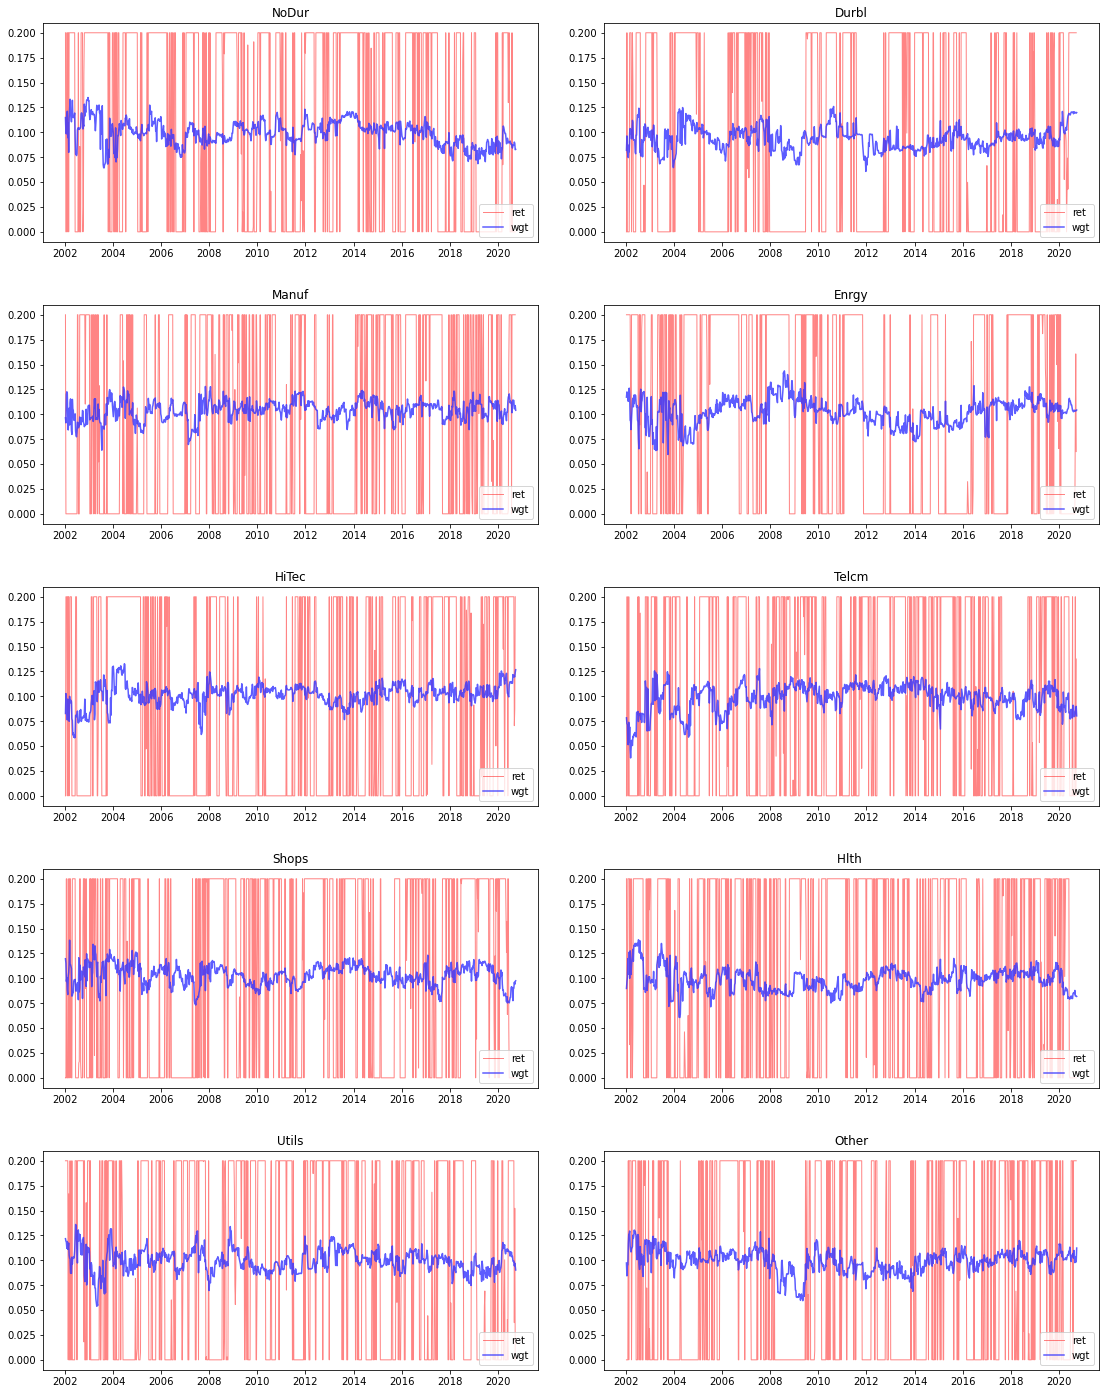

In [ ]:
w_pf = dict_saved_weights['sect_63_pl_wgt_qt_ecdf_1_2']
w_ret = dict_saved_weights['sect_63_pl_ret_qt_ecdf_1_2_63']

fig, axs = plt.subplots(5, 2, figsize=(16,20))
axs=axs.flatten()

for i, c in enumerate(w_pf.columns):
    df_plot = pd.DataFrame(index=w_pf.index,columns=['wgt', 'ret'])
    df_plot['ret']=w_ret[c]
    df_plot['wgt']=w_pf[c]
    df_plot.dropna()

    axs[i].plot(df_plot.index,df_plot['ret'],'-',color='#FF3333',label='ret',linewidth=1, alpha=0.6)
    axs[i].plot(df_plot.index,df_plot['wgt'],'-',color='#3333FF', label='wgt', alpha=0.8)
    axs[i].set_title(c)
    axs[i].legend(loc="lower right")
    
fig.tight_layout(pad=3.0) 
plt.show()


In [ ]:
df_graph_data = df_store_all.copy()
ret_horizon_rename = df_graph_data['Return Horizon'].replace(126,'6M forecast')
ret_horizon_rename = ret_horizon_rename.replace(63,'3M forecast')
ret_horizon_rename = ret_horizon_rename.replace(21,'1M forecast')
df_graph_data['Return Horizon'] = ret_horizon_rename

### Summary Statistics table

In [ ]:
df_graph_data.groupby(['Prediction','Return Horizon','Gamma']).mean()[
    ['Sharpe TC 5 bps', 'Ann. volatility','Max Drawdown','Avg. Weekly TO']].round(3)

Sharpe TC 5 bps  Ann. volatility  \
Prediction Return Horizon Gamma                                     
ret        1M forecast    1                0.468            0.197   
                          3                0.473            0.184   
                          10               0.503            0.167   
           3M forecast    1                0.463            0.198   
                          3                0.459            0.186   
                          10               0.505            0.168   
           6M forecast    1                0.485            0.189   
                          3                0.497            0.178   
                          10               0.541            0.165   
wgt        1M forecast    1                0.498            0.193   
                          3                0.499            0.192   
                          10               0.505            0.188   
           3M forecast    1                0.493            0.193   
                          3                0.485            0.192   
                          10               0.491            0.187   
           6M forecast    1                0.494            0.192   
                          3                0.494            0.189   
                          10               0.506            0.184   
wgt1n      1M forecast    1                0.496            0.193   
                          3                0.500            0.192   
                          10               0.507            0.188   
           3M forecast    1                0.481            0.194   
                          3                0.491            0.192   
                          10               0.493            0.187   
           6M forecast    1                0.491            0.192   
                          3                0.495            0.190   
                          10               0.507            0.184   

                                 Max Drawdown  Avg. Weekly TO  
Prediction Return Horizon Gamma                                
ret        1M forecast    1            -0.517           0.579  
                          3            -0.481           0.555  
                          10           -0.443           0.463  
           3M forecast    1            -0.493           0.504  
                          3            -0.470           0.482  
                          10           -0.442           0.385  
           6M forecast    1            -0.485           0.434  
                          3            -0.452           0.395  
                          10           -0.426           0.310  
wgt        1M forecast    1            -0.541           0.067  
                          3            -0.540           0.060  
                          10           -0.530           0.076  
           3M forecast    1            -0.538           0.066  
                          3            -0.536           0.087  
                          10           -0.523           0.091  
           6M forecast    1            -0.537           0.085  
                          3            -0.535           0.093  
                          10           -0.521           0.105  
wgt1n      1M forecast    1            -0.545           0.087  
                          3            -0.539           0.063  
                          10           -0.530           0.060  
           3M forecast    1            -0.539           0.096  
                          3            -0.535           0.076  
                          10           -0.522           0.090  
           6M forecast    1            -0.539           0.095  
                          3            -0.533           0.102  
                          10           -0.525           0.082

### Plot Sharpe Net TC (5 bps) versus MCS Pvalue by bucket of Return Horizon x Gamma

In [ ]:
x_feature = 'MCS 3-year roll Sharpe (5 bps)'
y_feature = 'Sharpe TC 5 bps'

df_graph_data[y_feature] = df_graph_data[y_feature].astype(float)
df_graph_data[x_feature] = df_graph_data[x_feature].astype(float)
df_graph_data['Gamma'] = df_graph_data['Gamma'].astype('category')
df_graph_data['Return Horizon'] = df_graph_data['Return Horizon'].astype('category')

scatter_plot = ggplot(df_graph_data) 
scatter_plot += aes(x=x_feature, y=y_feature, fill='Prediction', color='Prediction', shape='Prediction', na_mr=True) 
scatter_plot += geom_point(show_legend=True,size=2) 

color_dict = {'ret': '#2B3080', 
              'wgt': '#F04A32', 
              'wgt1n': '#F4E45F'}

scatter_plot += scale_fill_manual(values=color_dict)
scatter_plot += scale_color_manual(values=color_dict)

scatter_plot += facet_grid(facets='Gamma ~ Return Horizon', scales='fixed', labeller='label_both')
scatter_plot += scale_x_continuous(breaks=np.array([0,0.5,1]))

scatter_plot += theme(title=None,
                     legend_position="top",
                     legend_text=element_text(size=8),
                     legend_title=element_blank(),
                     legend_box_margin=2, 
                     strip_background = element_rect(color = "black", fill="lightgrey"),
                     panel_background=element_rect(fill='lightgrey',alpha=0.1),
                      panel_grid=element_line(color='grey',alpha=0.3),
                     figure_size=(12,5)
                     )

scatter_plot += labs(x='Model Confidence Set Pvalue (3Y-rolling Sharpe Net TC 5 bps)', ye='Sharpe Net TC (5 bps)')

scatter_plot

### Average weekly turnover

In [ ]:
y_feature = 'Avg. Weekly TO'
df_graph_data.loc[:,y_feature] = df_graph_data.loc[:,y_feature].astype(float)
df_graph_data.loc[:,'Max Weight'] = df_graph_data.loc[:,'Max Weight'].astype(float)
df_graph_data['Max Weight'] = pd.Series(["{0:.0f}%".format(val * 100) for  val in df_graph_data['Max Weight']], 
                                        index = df_graph_data.index)

scatter_plot = ggplot(data=df_graph_data) 
scatter_plot += aes(x='Prediction', y=y_feature, color='Max Weight', fill='Max Weight', shape='Max Weight')

# using html color codes:
color_dict = {'20%': '#2B3080', 
              '30%': '#F04A32', 
              '40%': '#F4E45F'}

scatter_plot += scale_fill_manual(values=color_dict)
scatter_plot += scale_color_manual(values=color_dict)

scatter_plot += geom_jitter(show_legend=True, size=2)

scatter_plot += theme(
                     title=None,
                     legend_position='right',
                     legend_direction='vertical',
                     legend_title_align='center',
                     legend_text=element_text(size=8),
                     legend_title=element_text(text='Max weight',size=8,weight='bold',va='center'),
                     legend_key=element_rect(fill='white', alpha=.3),
                     legend_key_size=20,
                     legend_box='vertical',
                     plot_background=element_rect(fill='white', alpha=.3),
                     panel_background=element_rect(fill='white'),
                     strip_background = element_rect(colour = "black", fill="white", alpha=1),
                     line=element_line(color='white'),
                     figure_size=(8,5),
                     panel_grid=element_line(color='grey'),
                     panel_grid_major=element_line(size=0.5, alpha=1)
                     )

scatter_plot += labs(x='',y='Turnover')

scatter_plot

### Average Max Drawdown

In [ ]:
df_mdd = df_graph_data.groupby(['Prediction','Return Horizon','Gamma'])['Max Drawdown'].mean().reset_index()
df_mdd['Gamma'] = df_mdd['Gamma'].astype('category')

bar_chart = ggplot(df_mdd) 
bar_chart += aes(x='Gamma', y='Max Drawdown', fill='Prediction', width=0.5, na_mr=True)
bar_chart += geom_bar(stat='identity',position='dodge')  

color_dict = {'ret': '#2B3080', 
              'wgt': '#F04A32', 
              'wgt1n': '#F4E45F'}

bar_chart += scale_fill_manual(values=color_dict)
bar_chart += coord_cartesian(ylim = (-0.6, -0.4)) # zoom in graph

bar_chart += facet_grid(facets='~ Return Horizon', scales='fixed')

bar_chart += theme(title=None,
                   legend_position="right",
                   legend_text=element_text(size=8),
                   legend_title=element_blank(),
                   strip_background = element_rect(color = "black", fill="lightgrey"),
                   panel_background=element_rect(fill='lightgrey',alpha=0.1),
                   panel_grid=element_line(color='grey',alpha=0.3),
                   figure_size=(6,3)
                   )

bar_chart += labs( y='Average Max Drawdown')
bar_chart